## Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

In [3]:
!apt-get install crappify

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package crappify


Prepare the input data by crappifying images.

In [4]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)



#from crappify import *

In [11]:
!dir {path_hr}

Abyssinian_100.jpg		   keeshond_186.jpg
Abyssinian_100.mat		   keeshond_187.jpg
Abyssinian_101.jpg		   keeshond_188.jpg
Abyssinian_101.mat		   keeshond_189.jpg
Abyssinian_102.jpg		   keeshond_18.jpg
Abyssinian_102.mat		   keeshond_190.jpg
Abyssinian_103.jpg		   keeshond_191.jpg
Abyssinian_104.jpg		   keeshond_192.jpg
Abyssinian_105.jpg		   keeshond_193.jpg
Abyssinian_106.jpg		   keeshond_194.jpg
Abyssinian_107.jpg		   keeshond_195.jpg
Abyssinian_108.jpg		   keeshond_196.jpg
Abyssinian_109.jpg		   keeshond_197.jpg
Abyssinian_10.jpg		   keeshond_198.jpg
Abyssinian_110.jpg		   keeshond_199.jpg
Abyssinian_111.jpg		   keeshond_19.jpg
Abyssinian_112.jpg		   keeshond_1.jpg
Abyssinian_113.jpg		   keeshond_200.jpg
Abyssinian_114.jpg		   keeshond_20.jpg
Abyssinian_115.jpg		   keeshond_21.jpg
Abyssinian_116.jpg		   keeshond_22.jpg
Abyssinian_117.jpg		   keeshond_23.jpg
Abyssinian_118.jpg		   keeshond_24.jpg
Abyssinian_119.jpg		   keeshond_25.jpg
Abyssinian_11.jpg		   keeshond_26.jpg
Abyssinian_12

Uncomment the first time you run this notebook.

In [7]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [9]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [10]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [12]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
data_gen = get_data(bs,size)

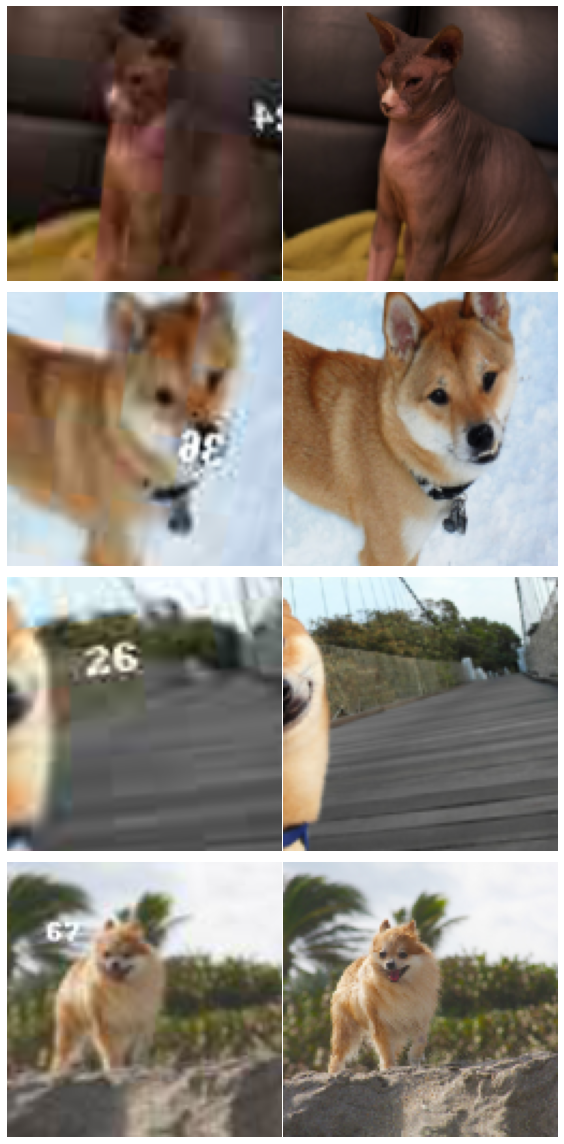

In [15]:
data_gen.show_batch(4)

In [16]:
wd = 1e-3

In [17]:
y_range = (-3.,3.)

In [18]:
loss_gen = MSELossFlat()

In [19]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [20]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [21]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [22]:
learn_gen.unfreeze()

In [23]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

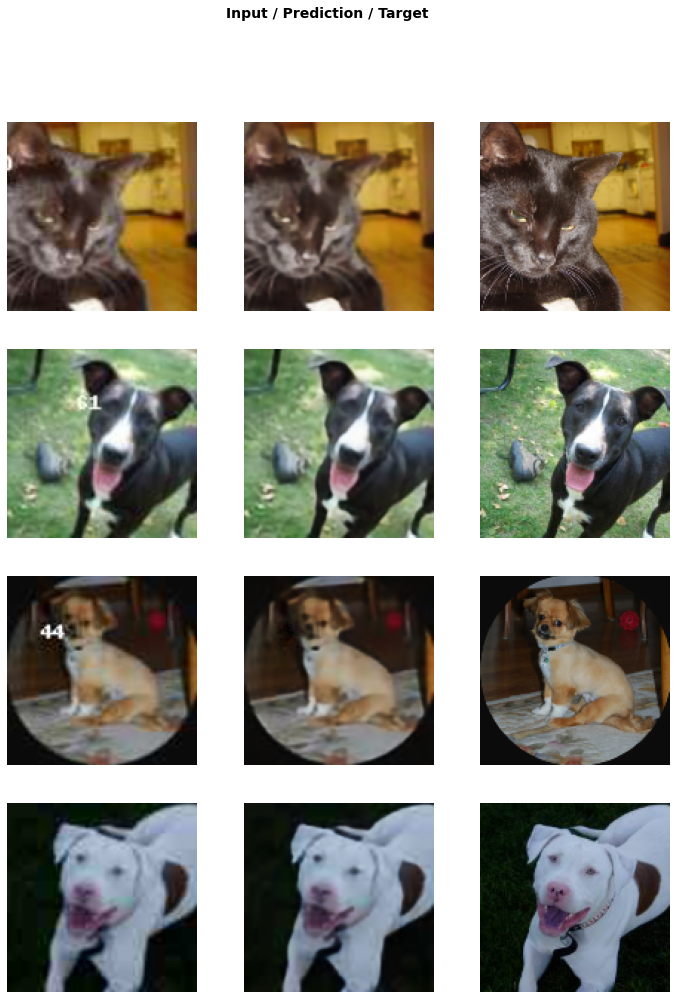

In [24]:
learn_gen.show_results(rows=4)

In [25]:
learn_gen.save('gen-pre2')

# even though we are able to remove the number we need a loss function that does a 
# good work of matching pixel to the original picture
# so we use something called GAN

## Save generated images

In [26]:
learn_gen.load('gen-pre2');

In [27]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [28]:
path_gen.mkdir(exist_ok=True)

In [29]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [30]:
save_preds(data_gen.fix_dl)

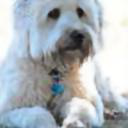

In [31]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [32]:
learn_gen=None
gc.collect()

# this is how you can avoid restarting your notebook
# by initilaising garbage collector

22

Pretrain the critic on crappy vs not crappy.

In [33]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [34]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

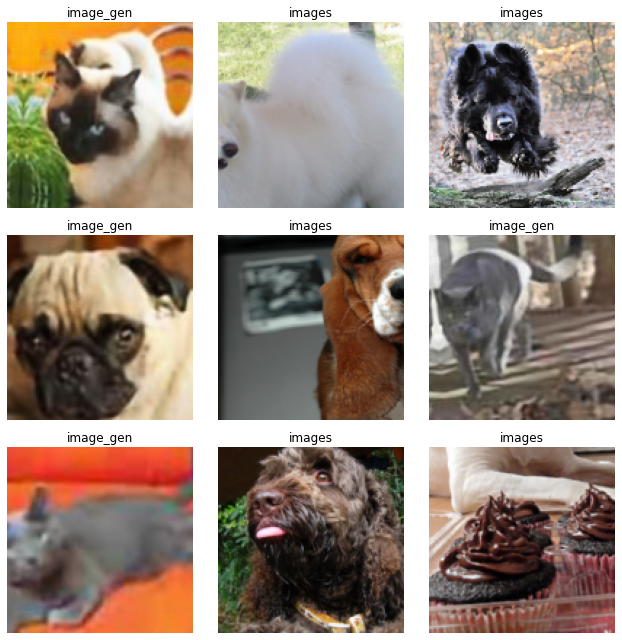

In [35]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [36]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [37]:
# we dont use resent as it is used in generator
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [38]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [39]:
learn_critic.fit_one_cycle(6, 1e-3)

In [40]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [41]:
learn_crit=None
learn_gen=None
gc.collect()

19450

In [42]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [43]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [44]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [45]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [46]:
lr = 1e-4

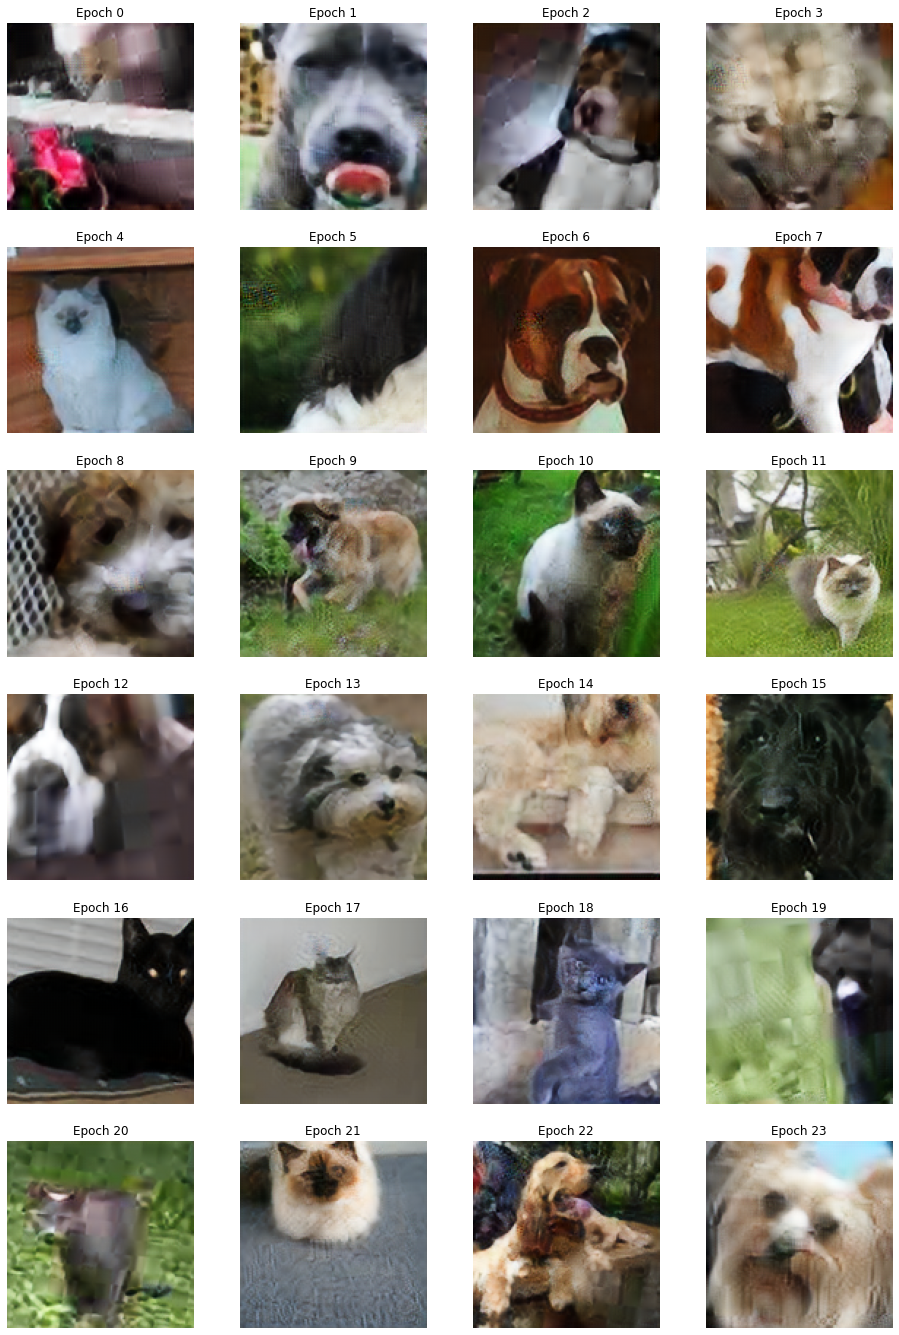

Buffered data was truncated after reaching the output size limit.

In [ ]:
learn.fit(40,lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

## fin